In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import os

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

In [3]:
!nvidia-smi

Wed Nov  3 20:59:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   53C    P0   182W / 300W |   6425MiB / 32480MiB |     77%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   33C    P0    39W / 300W |     10MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding =4), #cifar 10 image size : 32x32
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root = './data', train=True, 
                download= True, transform = transform_train)
test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False,
                download=True, transform= transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=96,
                                          shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=96,
                                         shuffle =True, num_workers =2)

#num_workers =2 인지 4인지 or batch_size test의 경우는 왜 100인지?

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu6(self.bn1(self.conv1(x)))
        out = F.relu6(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


In [6]:
class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        # NOTE: change pooling kernel_size 7 -> 4 for CIFAR10
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [7]:
net = MobileNetV2()
net = net.to(device)

if device == 'cuda:2':
#     net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [13]:
# net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.045
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.00004)

loss_list = []
accuracy_list=[]

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)#예측값과 실제 타깃값
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        
    accuracy_list.append(100. * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    loss_list.append(loss)
    print('Test average loss:', loss / total)    

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


        
#learning rate를 바꾸기
def adjust_learning_rate(optimizer, epoch):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        if epoch <=150 and epoch != 0:
            param_group['lr'] = lr * 0.98
        print(param_group['lr'])

### Learning Rate decay only till 150, total 200 epochs

In [14]:
for epoch in range(0, 200):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)

0.045

[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.78125
Current benign train loss: 0.69399094581604

Current batch: 100
Current benign train accuracy: 0.7395833333333334
Current benign train loss: 0.7248758673667908

Current batch: 200
Current benign train accuracy: 0.7604166666666666
Current benign train loss: 0.7637732625007629

Current batch: 300
Current benign train accuracy: 0.7291666666666666
Current benign train loss: 0.8263978958129883

Current batch: 400
Current benign train accuracy: 0.6979166666666666
Current benign train loss: 0.8381826877593994

Current batch: 500
Current benign train accuracy: 0.7708333333333334
Current benign train loss: 0.6537759900093079

Total benign train accuarcy: 73.286
Total benign train loss: 399.3886151313782

[ Test epoch: 0 ]

Test accuarcy: 74.7
Test average loss: 0.007824400568008422
Model Saved!
0.0441

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.8541666666666666
Current benign train loss


Current batch: 300
Current benign train accuracy: 0.90625
Current benign train loss: 0.27469736337661743

Current batch: 400
Current benign train accuracy: 0.875
Current benign train loss: 0.35122907161712646

Current batch: 500
Current benign train accuracy: 0.8854166666666666
Current benign train loss: 0.3254036009311676

Total benign train accuarcy: 87.632
Total benign train loss: 183.65094298124313

[ Test epoch: 9 ]

Test accuarcy: 84.69
Test average loss: 0.004868845592439174
Model Saved!
0.036768276309939604

[ Train epoch: 10 ]

Current batch: 0
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.23855715990066528

Current batch: 100
Current benign train accuracy: 0.84375
Current benign train loss: 0.46466580033302307

Current batch: 200
Current benign train accuracy: 0.9375
Current benign train loss: 0.2095801830291748

Current batch: 300
Current benign train accuracy: 0.8645833333333334
Current benign train loss: 0.3360784351825714

Current batch: 


Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.09680766612291336

Total benign train accuarcy: 91.888
Total benign train loss: 119.53969780355692

[ Test epoch: 18 ]

Test accuarcy: 87.0
Test average loss: 0.00453083765655756
Model Saved!
0.030655468090795137

[ Train epoch: 19 ]

Current batch: 0
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.17804335057735443

Current batch: 100
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.171657994389534

Current batch: 200
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.12367705255746841

Current batch: 300
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.21094530820846558

Current batch: 400
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.21518997848033905

Current batch: 500
Current benign train accuracy: 0.8958333333333334
Current benign t


Test accuarcy: 89.43
Test average loss: 0.0035732117250561715
Model Saved!
0.02555892791775266

[ Train epoch: 28 ]

Current batch: 0
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.17578792572021484

Current batch: 100
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.14997084438800812

Current batch: 200
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.12070494145154953

Current batch: 300
Current benign train accuracy: 0.9375
Current benign train loss: 0.19559438526630402

Current batch: 400
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.17432010173797607

Current batch: 500
Current benign train accuracy: 0.90625
Current benign train loss: 0.2627948224544525

Total benign train accuarcy: 94.452
Total benign train loss: 81.95297311618924

[ Test epoch: 28 ]

Test accuarcy: 89.65
Test average loss: 0.0038267250992357732
Model Saved!
0.025047749359397607

[ Train e


Current batch: 100
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.10354412347078323

Current batch: 200
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.05776814743876457

Current batch: 300
Current benign train accuracy: 0.9375
Current benign train loss: 0.10412716120481491

Current batch: 400
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.11756446212530136

Current batch: 500
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.16876597702503204

Total benign train accuarcy: 96.12
Total benign train loss: 56.95323377009481

[ Test epoch: 37 ]

Test accuarcy: 90.27
Test average loss: 0.003627662343531847
Model Saved!
0.020883504974794645

[ Train epoch: 38 ]

Current batch: 0
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.10401982069015503

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss:


Current batch: 300
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.04978795722126961

Current batch: 400
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.06851033866405487

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.10305073112249374

Total benign train accuarcy: 97.196
Total benign train loss: 41.47823019232601

[ Test epoch: 46 ]

Test accuarcy: 90.34
Test average loss: 0.003848439061641693
Model Saved!
0.017411575538168883

[ Train epoch: 47 ]

Current batch: 0
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.05955251678824425

Current batch: 100
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.05291653797030449

Current batch: 200
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.1215357556939125

Current batch: 300
Current benign train accuracy: 0.9583333333333334
Current benign


Current batch: 400
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.04181515797972679

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.044595424085855484

Total benign train accuarcy: 97.93
Total benign train loss: 29.953443425241858

[ Test epoch: 55 ]

Test accuarcy: 90.73
Test average loss: 0.0039882538430392744
Model Saved!
0.01451686214010837

[ Train epoch: 56 ]

Current batch: 0
Current benign train accuracy: 0.96875
Current benign train loss: 0.04167678952217102

Current batch: 100
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.037981320172548294

Current batch: 200
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.09474986046552658

Current batch: 300
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.06866658478975296

Current batch: 400
Current benign train accuracy: 0.9791666666666666
Current benign train l


Total benign train accuarcy: 98.728
Total benign train loss: 19.128779346123338

[ Test epoch: 64 ]

Test accuarcy: 91.47
Test average loss: 0.004247386515140533
Model Saved!
0.012103401322467249

[ Train epoch: 65 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.034116413444280624

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.020522648468613625

Current batch: 200
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.06014934554696083

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.02765638381242752

Current batch: 400
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.02679525315761566

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0068177892826497555

Total benign train accuarcy: 98.814
Total benign train loss: 17.96562384464778

[ Test epoch: 65 ]

Test ac


Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.03645607829093933

Current batch: 100
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.026252053678035736

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0077699157409369946

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.003953055012971163

Current batch: 400
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.05463359132409096

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.025408126413822174

Total benign train accuarcy: 99.1
Total benign train loss: 13.379206153331324

[ Test epoch: 74 ]

Test accuarcy: 91.58
Test average loss: 0.004258721439912915
Model Saved!
0.009889360091434759

[ Train epoch: 75 ]

Current batch: 0
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.037687700241


Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.00400581257417798

Current batch: 400
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.027017170563340187

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.00298722623847425

Total benign train accuarcy: 99.5
Total benign train loss: 7.824231397360563

[ Test epoch: 83 ]

Test accuarcy: 91.88
Test average loss: 0.004383049000240862
Model Saved!
0.008245231845132941

[ Train epoch: 84 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0011305209482088685

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.002304007997736335

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.011255254037678242

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.007253402378410101

Current batch: 400
Current benign train accuracy: 0


Test accuarcy: 91.96
Test average loss: 0.004467686875164509
Model Saved!
0.006874443599123835

[ Train epoch: 93 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.03456244245171547

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0005179975996725261

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0003784439468290657

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0020766782108694315

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0008472452755086124

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.008094782009720802

Total benign train accuarcy: 99.666
Total benign train loss: 5.588185656393762

[ Test epoch: 93 ]

Test accuarcy: 91.75
Test average loss: 0.004572244065254927
Model Saved!
0.006736954727141358

[ Train epoch: 94 ]

Current batch: 0
Current benign


Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0014893956249579787

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.003054387168958783

Total benign train accuarcy: 99.732
Total benign train loss: 4.424756711669033

[ Test epoch: 102 ]

Test accuarcy: 91.76
Test average loss: 0.004608532117307186
Model Saved!
0.00561692092732624

[ Train epoch: 103 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.005855646450072527

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.04486727714538574

Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.007889644242823124

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.012131299823522568

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0023715351708233356

Current batch: 5


Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0004095450567547232

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.00910522136837244

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0032012108713388443

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.004101613070815802

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.007054632995277643

Total benign train accuarcy: 99.856
Total benign train loss: 2.6600438913228572

[ Test epoch: 112 ]

Test accuarcy: 91.97
Test average loss: 0.004626032311469317
Model Saved!
0.004589433348155853

[ Train epoch: 113 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.023743435740470886

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.013235394842922688

Current batch: 200
Current be


Total benign train accuarcy: 99.892
Total benign train loss: 1.9190389460163715

[ Test epoch: 121 ]

Test accuarcy: 92.39
Test average loss: 0.004515885217417963
Model Saved!
0.0038264297834704228

[ Train epoch: 122 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.000646474480163306

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0005466560833156109

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0015428474871441722

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0016683097928762436

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.00887164194136858

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0005362474475987256

Total benign train accuarcy: 99.874
Total benign train loss: 2.2354062732410966

[ Test epoch: 122 ]

Test accuarcy: 92.22
Test average loss: 0.004589649778034


Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0003341303381603211

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0008086529560387135

Total benign train accuarcy: 99.916
Total benign train loss: 1.7988661057133868

[ Test epoch: 131 ]

Test accuarcy: 92.24
Test average loss: 0.004681651773303747
Model Saved!
0.003126471723538286

[ Train epoch: 132 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.008582419715821743

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.002941117389127612

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.001040954957716167

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0009070883388631046

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0013490458950400352

Current batch: 500
Current benign train a


Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0004148614825680852

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0011124374577775598

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0015090079978108406

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0005888217710889876

Total benign train accuarcy: 99.936
Total benign train loss: 1.3807313491888635

[ Test epoch: 141 ]

Test accuarcy: 92.3
Test average loss: 0.004602206408232451
Model Saved!
0.0025545550268059737

[ Train epoch: 142 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.001788955763913691

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0012544473866000772

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.00019063845684286207

Current batch: 300
Current benign train accuracy: 1.0


Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0003426469338592142

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.00013731644139625132

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0009442130685783923

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0009531343239359558

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0005383003735914826

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0027347032446414232

Total benign train accuarcy: 99.944
Total benign train loss: 1.2147029716979887

[ Test epoch: 151 ]

Test accuarcy: 92.18
Test average loss: 0.004693025907501578
Model Saved!
0.0021733209559569445

[ Train epoch: 152 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.00034667563159018755

Current batch: 100
Current benign train accuracy: 1.


Total benign train accuarcy: 99.954
Total benign train loss: 1.0311301651854592

[ Test epoch: 160 ]

Test accuarcy: 92.24
Test average loss: 0.00459421353470417
Model Saved!
0.0021733209559569445

[ Train epoch: 161 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0009170537232421339

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.00019594198965933174

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0009643435478210449

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0015487195923924446

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0009296138887293637

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0006871785153634846

Total benign train accuarcy: 99.952
Total benign train loss: 0.9667152175679803

[ Test epoch: 161 ]

Test accuarcy: 92.2
Test average loss: 0.0046359096262


Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0008961638086475432

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.003067092737182975

Total benign train accuarcy: 99.964
Total benign train loss: 0.999323532130802

[ Test epoch: 170 ]

Test accuarcy: 92.28
Test average loss: 0.004879832597263157
Model Saved!
0.0021733209559569445

[ Train epoch: 171 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.00043592488509602845

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0005698782624676824

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0004096177581232041

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0007791666430421174

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0018676555482670665

Current batch: 500
Current benign train accuracy: 1.0


Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0007375209243036807

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.001885905978269875

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.00018827263556886464

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0016943207010626793

Total benign train accuarcy: 99.948
Total benign train loss: 1.007425653457176

[ Test epoch: 180 ]

Test accuarcy: 92.1
Test average loss: 0.004816027875244618
Model Saved!
0.0021733209559569445

[ Train epoch: 181 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0002896221121773124

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0013797320425510406

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0028417969588190317

Current batch: 300
Current benign train accuracy: 1.0



Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.00034384222817607224

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.000300657149637118

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0008863864350132644

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.00035519266384653747

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0002977049443870783

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0002945483138319105

Total benign train accuarcy: 99.978
Total benign train loss: 0.8436855567142629

[ Test epoch: 190 ]

Test accuarcy: 92.27
Test average loss: 0.004805433796904981
Model Saved!
0.0021733209559569445

[ Train epoch: 191 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0008360747597180307

Current batch: 100
Current benign train accuracy: 1.0


Total benign train accuarcy: 99.95
Total benign train loss: 0.9843103772236645

[ Test epoch: 199 ]

Test accuarcy: 92.34
Test average loss: 0.00487251223474741
Model Saved!


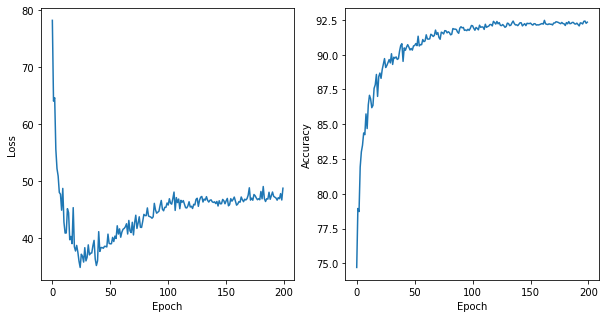

In [17]:
epochs = np.arange(0,200)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.plot(epochs,loss_list) 
plt.subplot(1,2,2) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.plot(epochs, accuracy_list) 
plt.show()